### This notebook takes about 2.5 hours to run

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pylab
import copy

###
from itertools import islice
from moviepy.editor import ImageSequenceClip
from moviepy.video.io.bindings import mplfig_to_npimage

from matplotlib import pylab as plt
from matplotlib.cm import binary
from collections import Counter
from tqdm import tqdm
from scipy import stats

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
import matplotlib
import matplotlib.animation as animation
from IPython.display import Video
import matplotlib as mpl

def build_animation(states, save_name):
    """
    A function that makes a very nice animation 
    
    Source: https://stackoverflow.com/questions/17212722/matplotlib-imshow-how-to-animate
    """
    
    fps = 3
    nSeconds = len(states)// fps

    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure( figsize=(8,8) )

    a = states[0]



    pylab.cla()
    im = pylab.imshow(a, vmin = 0, vmax = 6, cmap = pylab.cm.binary)


    def animate_func(i):
        if i % fps == 0:
            print( '.', end ='' )

        im.set_array(states[i])
        return [im]

    anim = animation.FuncAnimation(
                                   fig, 
                                   animate_func, 
                                   frames = nSeconds * fps,
                                   interval = 1000 / fps, # in ms
                                   )

    anim.save(save_name, fps=fps, extra_args=['-vcodec', 'libx264'])

    print('Done!')



In [3]:
class LatticeCell:
    """
    The general class for the lattice cells
    """
    def __init__(self, value):
        self.CA_value = value # value is the discrete value that indicaetes walls, particles, or empty
        self.incoming_particles = [] #particles going towards the same cell
        self.particle_contained = [] # particles inside one cell
        self.vectors = np.array([False,False, False, False, 
                                 False,False, False]) #the vector directions
        if value == 2: # walls get a friction direction that is opposite from particles 
            self.friction_direction = 1
        else:
            self.friction_direction = 0
            
    def get_value(self):
        """
        Visualization function
        """
        return np.count_nonzero(self.vectors)
        

In [4]:
rows = 50
columns = 50

def initialize():
    """
    This is the function to build the hopper. Similar to the one used in Baxter
    """
    config = np.zeros((rows, columns)).astype(object) 
    show_config = np.zeros((rows, columns))
    for i in range(rows):
        for j in range(columns):
            if i==0 or i==rows-1 or j==0 or j== columns-1:
                config[i, j] = LatticeCell(2)
                show_config[i, j] = 7
            else:
                config[i, j] = LatticeCell(0)
                show_config[i, j] = config[i, j].get_value()
            
     
    return config, show_config

def observe(config):
    
    """
    A function to observe the state of the CA
    config: the numpy array of latice cells
    """
    
    plt.figure(figsize = (10, 8))
    pylab.cla()
    pylab.imshow(config, vmin = 0, vmax = 7, cmap = pylab.cm.binary)

In [5]:
class Particle:
    """
    The general class for particles
    """
    def __init__(self, position, vector):
        """
        position: the current position of the particle
        vecotr: a number that indicates where the particle is going as explained in the paper
        """
        self.position = position 
        self.destination = None
        self.vector = vector 
        self.friction_direction = False # the direction that friction acts on the particle
        self.nested_neighbors = []

In [6]:
def fill_random(global_density, local_density, config, show_config):
    """
    A function to initialize the hopper with particles at random locations
    
    global_density: the capacity of the box
    local_density: a number between 0 and 7 indicating how many particles per one hexagonal cell
    """
    particles = []
    for row in range(1,rows-1):
        for column in range(1, columns-1):
            if random.uniform(0, 1) < global_density:
                num = round(stats.norm(local_density, 1).rvs(1)[0])
                if num > 6:
                    num =6
                elif num < 0:
                    num = 0
                indices = random.sample([0, 1, 2, 3, 4, 5], num)
                config[row, column].vectors[indices] = True
                
                show_config[row, column] =config[row, column].get_value()
                local_particles = [Particle([row, column], vector) for vector in indices]
                particles +=local_particles
                config[row, column].particle_contained += local_particles
     
    return config, particles, show_config

In [7]:
def get_next(row, column, vector):
    """
    A function that gets the next destination of a particle
    row, column: the current position
    
    vector: the direction of the next destination
    """
    if vector == -1:
        new_row,new_column = [row, column] #rest
    
    elif vector == 0:
        new_row,new_column = [(row-1)%rows, column] #top
        
    elif vector == 1:
        new_row,new_column = [(row-1)%rows, (column +1)%columns] #top right
        
    elif vector == 2:
        new_row,new_column = [(row+1)%rows, (column+1)%columns] #Bottom Right
        
    elif vector == 3:
        new_row,new_column = [(row+1)%rows, column] #bottom
        
    elif vector == 4:
        new_row,new_column = [(row+1)%rows, (column -1)%columns] #bottom left
        
    elif vector == 5:
        new_row,new_column = [(row-1)%rows, (column-1)%columns] #top left
    return new_row,new_column 


def get_all_neighbors(row, column):
    """
    A function to get the neighbors based on the assumption that the grid is hexagonal.
    """
    all_neighbors = []
    
    all_neighbors.append([row, column]) #rest

    all_neighbors.append([(row-1)%rows, column]) #top

    all_neighbors.append([(row-1)%rows, (column +1)%columns]) #top right

    all_neighbors.append([(row+1)%rows, (column+1)%columns]) #Bottom Right

    all_neighbors.append([(row+1)%rows, column]) #bottom

    all_neighbors.append([(row+1)%rows, (column -1)%columns]) #bottom left

    all_neighbors.append([(row-1)%rows, (column-1)%columns]) #top left
        
    return all_neighbors




                
def change_position(config, row, column):
    """
    A function used to change the position of particles when overlap happens - this is a simulation of pressure
    """
    
    if len(config[row, column].particle_contained)>1: # if there are overlap
        
        if [i.vector for i in config[row, column].particle_contained].count(-1) >1:
            
            # the particles that are overlapped
            scattering_particles = [particle for particle in config[row, column].particle_contained if\
                                   particle.vector ==-1]

            NNs = get_all_neighbors(row, column) # possible neighbors they could get to
            for particle in scattering_particles[:-1]:
                
                available = [i for i in NNs if (config[i[0], i[1]].vectors[-1]==False and config[i[0], i[1]].CA_value!=2)]
                if available:
                    new_row, new_column = random.choice(available)
                    particle.position = new_row, new_column
                    config[row, column].particle_contained.remove(particle)
                   
                    
                    config[new_row, new_column].CA_value = 1
                    config[new_row, new_column].particle_contained.append(particle)
                    config[new_row,new_column].vectors[particle.vector] = True
                    show_config[new_row,new_column] = config[new_row,new_column].get_value()
                    

          
gravity_vector = {0: -1, -1: 3, 1:2, 2:3, 5:4, 4:3, 3:3}
def add_gravity(particle):
    """
    Adding gravity using the rules explained in the paper
    partile: the partilce at which gravity will be added
    """
    particle.vector = gravity_vector[particle.vector]
    
    
#for the friction
def get_four_neighbors(row, column, config):
    """
    A function that obtains the four neighbors whose friction could affect the current particle
    """
    all_neighbors = []
    
    if config[(row+1)%rows, (column+1)%columns].CA_value ==2:
        all_neighbors.append(config[(row+1)%rows, (column+1)%columns].friction_direction)
    elif config[(row+1)%rows, (column+1)%columns].particle_contained :
        all_neighbors.append(config[(row+1)%rows, (column+1)%columns].particle_contained[0].friction_direction) #Bottom Right

    
    if config[(row+1)%rows, (column -1)%columns].CA_value ==2:
        all_neighbors.append(config[(row+1)%rows, (column -1)%columns].friction_direction)
    elif config[(row+1)%rows, (column -1)%columns].particle_contained :
        all_neighbors.append(config[(row+1)%rows, (column -1)%columns].particle_contained[0].friction_direction)

    
    if config[(row+1)%rows, (column -1)%columns].CA_value !=0 or config[(row+1)%rows, (column -1)%columns].particle_contained: # if bottom_left occupied, get top right
        
        if config[(row-1)%rows, (column +1)%columns].CA_value ==2:
            all_neighbors.append(config[(row-1)%rows, (column +1)%columns].friction_direction)
        elif config[(row-1)%rows, (column +1)%columns].particle_contained :
            all_neighbors.append(config[(row-1)%rows, (column +1)%columns].particle_contained[0].friction_direction)

        
    if config[(row+1)%rows, (column+1)%columns].CA_value !=0 or config[(row+1)%rows, (column+1)%columns].particle_contained: # if bottom_right occupied, get top left
        if config[(row-1)%rows, (column-1)%columns].CA_value ==2:
            all_neighbors.append(config[(row-1)%rows, (column-1)%columns].friction_direction)
        elif config[(row-1)%rows, (column-1)%columns].particle_contained :
            all_neighbors.append(config[(row-1)%rows, (column-1)%columns].particle_contained[0].friction_direction)

        
    return all_neighbors

In [8]:
def propagation_step(config, show_config, particles):
    """
    The first main step in updating the particles. This function propages particles to their next cell
    particles: the list that contains all particles
    
    """
    
    flow_counter = 0
    moving_particles = []
    active_sites = []
    collision_sites = [] #when more than 1 particle approach a site

          
    for my_particle in particles:
                
        if my_particle.vector == 3 or my_particle.vector == -1:
            row, column = my_particle.position
            
        
            my_particle.friction_direction = sum(get_four_neighbors(row, column, config))
            
            #print(my_particle.position, get_four_neighbors(row, column, config))
            
    
                
        if my_particle.friction_direction>=2:
            row, column = my_particle.position
            my_particle.friction_direction =2
      
        row, column = my_particle.position
        new_row,new_column = get_next(row, column, my_particle.vector) 
        my_particle.destination = [new_row,new_column]
        #if my_particle not in config[new_row,new_column].incoming_particles:
        config[new_row,new_column].incoming_particles.append(my_particle)
        if [new_row,new_column] not in active_sites:
            active_sites.append([new_row,new_column])
          
        
    #go through each active site and see if collision is happening there
    for row, column in active_sites:
        
        #wall
        if config[row, column].CA_value ==2:
            collision_sites.append([row, column])
        #two-body    
        elif len(config[row, column].incoming_particles) ==2:
            one, two = config[row, column].incoming_particles
            X = max(one.vector, two.vector)
            Y = min(one.vector, two.vector)
            distance = min(X-Y, 5-(X-Y-1))
            
            #
            if one.vector ==-1 or two.vector ==-1 or distance ==3 or distance ==2:
                  
                if one.position != two.position:
                    collision_sites.append([row, column])    
                else:
                    moving_particles = moving_particles+ config[row, column].incoming_particles
                    
            else:
                moving_particles = moving_particles+ config[row, column].incoming_particles
        
        #three-body
        elif len(config[row, column].incoming_particles) ==3:
            vectors = sorted([i.vector for i in config[row, column].incoming_particles])
            if [0,2,4] ==vectors or [1, 3, 5] == vectors:
                collision_sites.append([row, column])
            elif -1 in vectors:
                config[row, column].incoming_particles.sort(key=lambda x: x.vector)
                one, two, three = config[row, column].incoming_particles#to get the -1
                X = three.vector
                Y = two.vector
                distance = min(X-Y, 5-(X-Y-1))
                if distance ==2 or distance ==3:
                    collision_sites.append([row, column])
                else:
                    moving_particles = moving_particles+ config[row, column].incoming_particles   
            else:
                moving_particles = moving_particles+ config[row, column].incoming_particles   
 
        
        else:
            moving_particles = moving_particles+ config[row, column].incoming_particles
     
    #for all particles that are not colliding, propagate them ahead
    
    #print([particle.position for particle in moving_particles if moving_particles.count(particle)>1])
    for move_particle in moving_particles:
        row, column = move_particle.position
        new_row,new_column = move_particle.destination
        config[row, column].particle_contained.remove(move_particle)
        config[row, column].vectors[move_particle.vector] = False
        show_config[row, column] = config[row, column].get_value()
        if not config[row, column].particle_contained:
            config[row, column].CA_value = 0
            
            
        config[new_row,new_column].particle_contained.append(move_particle)
        config[new_row,new_column].CA_value = 1
        config[new_row,new_column].vectors[move_particle.vector] = True
        show_config[new_row,new_column] = config[new_row,new_column].get_value()
        
        config[new_row,new_column].incoming_particles = []
        move_particle.position = [new_row,new_column]
        move_particle.destination = None
    
    
        #gravity

        if move_particle.vector == -1:
            if random.uniform(0, 1) < g:
                r, c = get_next(new_row,new_column, 3)
                r_r, c_r = get_next(new_row,new_column, 2)
                r_l, c_l = get_next(new_row,new_column, 4)
                if config[r, c].CA_value ==0:
                    move_particle.vector = 3
                    config[new_row,new_column].vectors[-1] = False
                    config[new_row,new_column].vectors[move_particle.vector] = True
                elif config[r_r, c_r].CA_value ==0:
                    move_particle.vector = 2
                    config[new_row,new_column].vectors[-1] = False
                    config[new_row,new_column].vectors[move_particle.vector] = True

                elif config[r_l, c_l].CA_value ==0:
                    move_particle.vector = 4
                    config[new_row,new_column].vectors[-1] = False
                    config[new_row,new_column].vectors[move_particle.vector] = True

        else:
            if random.uniform(0, 1) < h:
                config[new_row,new_column].vectors[move_particle.vector] = False
                add_gravity(move_particle) 
                config[new_row,new_column].vectors[move_particle.vector] = True
        #emptying
        #"""
        if new_row == rows-1:
            
            particles.remove(move_particle)
            config[new_row,new_column].particle_contained.remove(move_particle)
            config[new_row,new_column].CA_value = 0
            config[new_row,new_column].vectors[move_particle.vector] = False
            show_config[new_row,new_column] = config[new_row,new_column].get_value()
            flow_counter+=1
            
        
        #"""
        
        
    return config, show_config, particles, collision_sites,  flow_counter

In [9]:
def scattering(config, pressuring_cells):
    """
    This function along with the "change_position" functin above work on simulating the pressure gradient
    They scatter particles in the high density regions
    pressuring_cells: the list that contains the cells with highest density
    """
    for row, column in pressuring_cells:
        
        if len(config[row, column].particle_contained) >1:
            change_position(config, row, column)
        else:
            pressuring_cells.remove([row, column])
    return config, pressured_cells        

In [10]:
def collision_step(config, collision_sites, pressured_cells):
    """
    The second main step of my model. Hold the collision locally and change the vectors accordingly
    collision_sites: the cell at which collision will happen (obtained from the propagation step)
    pressured_cells: the cells that have multiple particles (high pressure)
    """
    
    for site in collision_sites:
       
        row, column = site
        
        #wall collision
        if config[row, column].CA_value == 2:
            
            
            for particle in config[row, column].incoming_particles:
                curr_row, curr_column = particle.position
                config[curr_row, curr_column].vectors[particle.vector] = False
                if random.uniform(0, 1) < p3:
                    particle.vector =-1
                else:
                    
                    if random.uniform(0, 1) < b:
                        particle.vector = (particle.vector+3)%6

                    else:
                        particle.vector = mirror_vector[particle.vector]
                    
            config[row, column].incoming_particles = []
            
        # two-body collision    
        elif len(config[row, column].incoming_particles) == 2:
            #print("Tow Body Collision")
            
            # a particle with a rest particle
            if config[row, column].incoming_particles[0].vector==-1 or\
            config[row, column].incoming_particles[1].vector==-1:
                
                #knowing which one is the rest
                if config[row, column].incoming_particles[0].vector==-1:
                    rest_partic = config[row, column].incoming_particles[0]
                    collid_partic = config[row, column].incoming_particles[1]
                    #print(collid_partic.vector)
                elif config[row, column].incoming_particles[1].vector==-1:
                    rest_partic = config[row, column].incoming_particles[1]
                    collid_partic = config[row, column].incoming_particles[0]
                    #print(collid_partic.vector)
                else:
                    print("weirddd!!!!")
                    
               
                ## get them out:
                row_1, column_1 = collid_partic.position
                row_2, column_2 = rest_partic.position
                config[row_1, column_1].particle_contained.remove(collid_partic)
                config[row_2, column_2].particle_contained.remove(rest_partic)
                config[row_1, column_1].vectors[collid_partic.vector] = False
                config[row_2, column_2].vectors[rest_partic.vector] = False
                show_config[row_1, column_1] = config[row_1, column_1].get_value()
                show_config[row_2, column_2] = config[row_2, column_2].get_value()
                ##
                
                
                # pushing the rest down 
                in_vector = collid_partic.vector
                rrow_1, rcolumn_1 =  get_next(row, column, (in_vector)%6) 
                if not config[rrow_1, rcolumn_1].vectors[-1] :
                    
                    rest_partic.vector = (in_vector)%6
                    collid_partic.vector = -1
                    
                else:
            
                    collid_partic.vector = -1
                    
                    #else:
                     #   collid_partic.vector = random.choice([(in_vector+3)%6, (in_vector+2)%6, (in_vector+4)%6])

                config[row, column].incoming_particles = []
                
                ### get them in:
                    
                config[row, column].particle_contained+= [collid_partic, rest_partic]
                collid_partic.position = [row, column]
                rest_partic.position = [row, column]
                config[row, column].vectors[collid_partic.vector] =True
                config[row, column].vectors[rest_partic.vector] =True
                config[row,column].CA_value = 1
                show_config[row, column] = config[row,column].get_value()
                #change_position(config, row, column)
                pressured_cells.append([row, column])
                ###
            
                
            else: #non-rest two-body
                
                ###########################
                particle_1 = config[row, column].incoming_particles[0]
                particle_2 = config[row, column].incoming_particles[1]
                
                ## get them out:
                row_1, column_1 = particle_1.position
                row_2, column_2 = particle_2.position
                config[row_1, column_1].particle_contained.remove(particle_1)
                config[row_2, column_2].particle_contained.remove(particle_2)
                config[row_1, column_1].vectors[particle_1.vector] = False
                config[row_2, column_2].vectors[particle_2.vector] = False
                show_config[row_1, column_1] = config[row_1, column_1].get_value()
                show_config[row_2, column_2] = config[row_2, column_2].get_value()
                ##
                

                X = max(particle_1.vector, particle_2.vector)
                Y = min(particle_1.vector, particle_2.vector)
                distance = min(X-Y, 5-(X-Y-1))
                #config[row, column].incoming_particles = []
                
                # head-on collision
                if distance == 3 :
                    
                    if random.uniform(0, 1) < 0.5:
                        particle_1.vector = (particle_1.vector+1)%6
                        particle_2.vector = (particle_2.vector+1)%6
                        config[row, column].incoming_particles = []
                    else:
                        particle_1.vector = (particle_1.vector-1)%6
                        particle_2.vector = (particle_2.vector-1)%6
                        config[row, column].incoming_particles = []

                # angle collision
                # p
                elif distance == 2 :
                    if (particle_1.vector +2)%6 ==  particle_2.vector:
                        i = particle_1
                        i_2 = particle_2
                    else:
                        i = particle_2
                        i_2 = particle_1
                    
                    if random.uniform(0, 1) <= p:
                        i.vector = (i.vector+3)%6
                        i_2.vector = (i_2.vector+3)%6
                        i_2.vector = (i.vector-2)%6
                        i.vector = -1
                        
                        
                        
                        config[row, column].incoming_particles = []
                        #print("rest")

                    else:
                        
                        #print("Mirror")
                        i.vector, i_2.vector = i_2.vector,i.vector 
                        
                        config[row, column].incoming_particles = []

                else:
                    print(particle_1.vector, particle_2.vector)
                    #     config[row, column].CA_value)
                    #print(particle_1.sec_vector[-6:], particle_2.sec_vector[-6:])
                    #print("---")
                
                ### get them in:    
                config[row, column].particle_contained+= [particle_1, particle_2]
                particle_1.position = [row, column]
                particle_2.position = [row, column]
                config[row, column].vectors[particle_1.vector] =True
                config[row, column].vectors[particle_2.vector] =True
                config[row,column].CA_value = 1
                show_config[row, column] = config[row,column].get_value()
                ###
                
                
        #three-body collisions            
        elif len(config[row, column].incoming_particles) == 3:
            vectors = sorted([i.vector for i in config[row, column].incoming_particles])
            
            #non-rest three-body
            if [0,2,4] ==vectors or [1, 3, 5] == vectors:
                
                particle_1 = config[row, column].incoming_particles[0]
                particle_2 = config[row, column].incoming_particles[1]
                particle_3 = config[row, column].incoming_particles[2]
                
               
                ## get them out:
                row_1, column_1 = particle_1.position
                row_2, column_2 = particle_2.position
                row_3, column_3 = particle_3.position
                config[row_1, column_1].particle_contained.remove(particle_1)
                config[row_2, column_2].particle_contained.remove(particle_2)
                config[row_3, column_3].particle_contained.remove(particle_3)
                config[row_1, column_1].vectors[particle_1.vector] = False
                config[row_2, column_2].vectors[particle_2.vector] = False
                config[row_3, column_3].vectors[particle_3.vector] = False
                show_config[row_1, column_1] = config[row_1, column_1].get_value()
                show_config[row_2, column_2] = config[row_2, column_2].get_value()
                show_config[row_3, column_3] = config[row_3, column_3].get_value()
                ##

               
                config[row, column].incoming_particles = []
                if random.uniform(0, 1) <p:
                    r = random.choice([1, 2, 3])
                    #print(r)
                    if r==1:
                        particle_2.vector = (particle_1.vector)%6  
                        particle_3.vector = (particle_1.vector+3)%6
                        particle_1.vector = -1
                        #change_position(config, particle_1)

                    elif r==2:
                        particle_2.vector = (particle_1.vector+2)%6  
                        particle_3.vector = (particle_1.vector-1)%6
                        particle_1.vector = -1
                        #change_position(config, particle_1)
                    elif r==3:
                        particle_2.vector = (particle_1.vector+1)%6  
                        particle_3.vector = (particle_1.vector-2)%6
                        particle_1.vector = -1
                        #change_position(config, particle_1)
                else:
                    
                    particle_2.vector = (particle_1.vector+1)%6  
                    particle_3.vector = (particle_1.vector-1)%6
                    particle_1.vector = (particle_1.vector+3)%6 
                    
                ### get them in:    
                config[row, column].particle_contained+= [particle_1, particle_2, particle_3]
                particle_1.position = [row, column]
                particle_2.position = [row, column]
                particle_3.position = [row, column]
                config[row, column].vectors[particle_1.vector] =True
                config[row, column].vectors[particle_2.vector] =True
                config[row, column].vectors[particle_3.vector] =True
                config[row,column].CA_value = 1
                show_config[row, column] = config[row,column].get_value()
                ###
            
            #rest three-body
            elif -1 in vectors:
                config[row, column].incoming_particles.sort(key=lambda x: x.vector)
                one, two, three = config[row, column].incoming_particles#to get the -1
                
                ## get them out:
                row_1, column_1 = one.position
                row_2, column_2 = two.position
                row_3, column_3 = three.position
                config[row_1, column_1].particle_contained.remove(one)
                config[row_2, column_2].particle_contained.remove(two)
                config[row_3, column_3].particle_contained.remove(three)
                config[row_1, column_1].vectors[one.vector] = False
                config[row_2, column_2].vectors[two.vector] = False
                config[row_3, column_3].vectors[three.vector] = False
                show_config[row_1, column_1] = config[row_1, column_1].get_value()
                show_config[row_2, column_2] = config[row_2, column_2].get_value()
                show_config[row_3, column_3] = config[row_3, column_3].get_value()
                ##
                
                X = three.vector
                Y = two.vector
                distance = min(X-Y, 5-(X-Y-1))
                #head-on to rest
                if distance == 3:
                    if random.uniform(0, 1) < p:
                        one.vector = -1
                        two.vector = -1
                        three.vector = -1
                        
                    
                #angle to rest    
                else:
                    
                    one.vector = -1
                    three.vector = (two.vector+1)%6
                    two.vector = -1
                   
                
                config[row, column].incoming_particles = []    
                
                
                ### get them in:    
                config[row, column].particle_contained+= [one, two, three]
                one.position = [row, column]
                two.position = [row, column]
                three.position = [row, column]
                config[row, column].vectors[one.vector] =True
                config[row, column].vectors[two.vector] =True
                config[row, column].vectors[three.vector] =True
                config[row,column].CA_value = 1
                show_config[row, column] = config[row,column].get_value()
                #change_position(config, row, column)
                pressured_cells.append([row, column])
                ###    
                
            
     
    
        
    return config, collision_sites, pressured_cells              
                    
    

In [11]:
hole = 2
vectorizer_0 = np.vectorize(lambda x: LatticeCell(0))
vectorizer_2 = np.vectorize(lambda x: LatticeCell(2))
def initialize_4():
    """
    A function to build a different configuration of the hopper.
    """
    
    
    config, show_config = initialize()
    tile = 1
    for x in range(int(0.75*rows), rows):
        if x == 0:
            continue
        if x %2 !=0:
            tile +=1
        for y in range(tile-1):
            config[x, y] = LatticeCell(2)
            config[x, -y-1] = LatticeCell(2)

            show_config[x, y] =2
            show_config[x, -y-1] = 2

    
  
    
    config[30: , int(((columns-1)/2)) : int(((columns-1)/2))+hole+1] = vectorizer_0(config[30: , int(((columns-1)/2)) : int(((columns-1)/2))+hole+1])
    config[30: , int(((columns-1)/2))-hole : int(((columns-1)/2))+1] = vectorizer_0(config[30: , int(((columns-1)/2))-hole : int(((columns-1)/2))+1])

    show_config[30: , int(((columns-1)/2)) : int(((columns-1)/2))+hole+1] = 0
    show_config[30: , int(((columns-1)/2))-hole : int(((columns-1)/2))+1] = 0

    
   

    
    return config, show_config

In [12]:
def fill_random2(global_density, local_density, config, show_config):
    """
    A function to initailize with particles at random directions
    global_density: the capacity of the box
    local_density: a number between 0 and 7 indicating how many particles per one hexagonal cell
    """
    particles = []
    for row in range(10,rows-20):
        for column in range(1, columns-1):
            if random.uniform(0, 1) < global_density and config[row, column].CA_value !=2:
                num = round(stats.norm(local_density, 1).rvs(1)[0])
                if num > 6:
                    num =6
                elif num < 0:
                    num = 0
                indices = random.sample([3, 3, 3, 3, 3, 3], num)  #([0, 1, 2, 3, 4, 5], num)
                config[row, column].vectors[indices] = True
                
                show_config[row, column] =config[row, column].get_value()
                local_particles = [Particle([row, column], vector) for vector in indices]
                particles +=local_particles
                config[row, column].particle_contained += local_particles
     
    return config, particles, show_config

In [13]:
############################################################

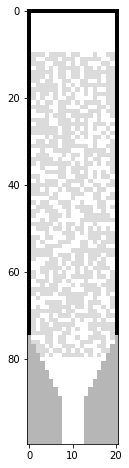

In [14]:
# an example of how the hopper looks like


p2 = 0 # disspation of rest particles
p3 = 0 # dissipation of walls
b = 0.5
p=0.1
mirror_vector = {0:3, 3:0, 1:5, 5:1, 4:2, 2:4}
g = 0.7
h = 0.3
tracking_sites = [(88, 7),(87, 8), (86, 9), (85, 10), (86, 11), (87, 12), (88, 13)]

rows=100
columns = 21
particles = []
config, show_config = initialize_4()


config[-1, int(((columns-1)/2))-hole:int(((columns-1)/2))+hole+1] =\
vectorizer_0(config[-1, int(((columns-1)/2))-hole:int(((columns-1)/2))+hole+1])
show_config[-1, int(((columns-1)/2))-hole:int(((columns-1)/2))+hole+1] = 0



#config, particles, show_config = fill_custom(config, show_config)
config, particles, show_config = fill_random2(0.9, 1, config, show_config)

observe(show_config)


In [15]:
def checker(particles, config):
    """
    A function that acts on the friction and checks if the arch is formed
    particles: the list that contains all particles
    config: the 2d grid
    """
    
    
    positions = [tuple(i.position) for i in particles] # check the arch confugration
    if len(set(tracking_sites).intersection(set(positions))) ==  len(tracking_sites):
        for r,c in tracking_sites:# tracking sites are the sites that could form an arch
            
            #"""
            parc = config[r, c].particle_contained[0]
            particles.remove(parc)
            config[r,c].particle_contained.remove(parc)
            
            config[r,c].vectors[parc.vector] = False
            show_config[r,c] = config[r,c].get_value()
            config[-1,c].CA_value = 2
            #"""

In [16]:
# producing the phase transition diagram


densities = [0.05, 0.08, 0.1, 0.13, 0.16, 0.21, 0.28, 0.35, 0.39, 0.41, 0.46, 0.5, 
              0.6, 0.7, 0.8, 0.9, 1.0]

all_rates = [] # storting the different flow rates

# for each density, I run 30 iterations
for density in tqdm(densities):
    averager = []
    for iterr in range(30):
        # start a new hopper configuration:
        particles = []
        config, show_config = initialize_4()
        config[-1, int(((columns-1)/2))-hole:int(((columns-1)/2))+hole+1] =\
        vectorizer_0(config[-1, int(((columns-1)/2))-hole:int(((columns-1)/2))+hole+1])
        show_config[-1, int(((columns-1)/2))-hole:int(((columns-1)/2))+hole+1] = 0

        config, particles, show_config = fill_random2(density, 1, config, show_config)

        # initialize the storing lists
        states = []
        states.append(np.copy(show_config))
        pressured_cells = []

        flow_rates = [] # flow rate for each iteration

        for i in range(400):
            checker(particles, config)
            config, show_config, particles, collision_sites, flow_counter = propagation_step(config, show_config,particles)
            config, collision_sites, pressured_cells   = collision_step(config, collision_sites, pressured_cells)
            config, pressured_cells = scattering(config, pressured_cells)
            states.append(np.copy(show_config))
            flow_rates.append(flow_counter)
            
        averager.append(np.mean(flow_rates))    
    all_rates.append(averager)



100%|██████████| 17/17 [48:28<00:00, 171.09s/it]


Text(0.5, 1.0, 'Fluid-Solid Phase Change (Jamming Transition)')

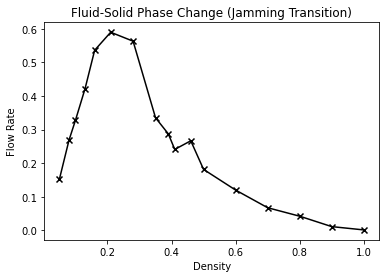

In [17]:
plt.scatter(densities, [np.mean(i) for i in all_rates], color  = 'black', marker = 'x')
plt.plot(densities, [np.mean(i) for i in all_rates], color = 'black')
plt.xlabel("Density")
plt.ylabel("Flow Rate")
plt.title("Fluid-Solid Phase Change (Jamming Transition)")